<a href="https://colab.research.google.com/github/Adrian-Muino/DMML2022_Geneva/blob/main/Mandatory_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A. Introduction

In this colab we will use the data provided for the competition

#B. Prerequisites

##Installations

In [1]:
#Installation
!pip install sentence-transformers
!python -m spacy download fr_core_news_sm
!python -m spacy link fr_core_news_sm fr
!python -m spacy download fr_core_news_md
!pip install tensorflow_hub
!pip install tensorflow_text
! pip install kaggle
!mkdir ~/.kaggle
# download the dataset from the competition page
! kaggle competitions download -c detecting-french-texts-difficulty-level-2022
!unzip detecting-french-texts-difficulty-level-2022.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.6 MB/s 
     |████████████████████████████████| 5.8 MB 30.5 MB/s 
     |████████████████████████████████| 1.3 MB 63.0 MB/s 
     |████████████████████████████████| 182 kB 76.1 MB/s 
     |████████████████████████████████| 7.6 MB 47.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=29d7192f0e285e17c192900f76058701247b1050aab67113dc97f6b166f90dd0
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 14.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ As of spaCy v3.0, mode

##Imports

In [2]:
import string
import re
from dmml_geneva_function import *
import pandas as pd

import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#C. Exploratory data analysis

##Loading the data

In [8]:
# load the data from our github repository
training_data = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Data/training_data.csv'
unlabelled_data = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Data/unlabelled_test_data.csv'

df = df_train = pd.read_csv(training_data)
df_unlabeled = df_test = pd.read_csv(unlabelled_data)


In [9]:
df.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


In [10]:
df_unlabeled.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


##Basic computations

In [11]:
# How many sentences of each category
df_train['difficulty'].value_counts()

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

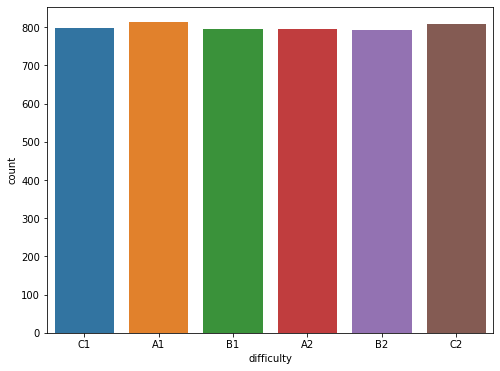

In [12]:
plt.figure(figsize=(8,6))
sns.countplot(x=df_train.difficulty)
plt.show()

### Baseline

In [13]:
# Base line calculation
difficulty_A1_count = df.loc[df["difficulty"] == "A1"].shape[0]
difficulty_A2_count = df.loc[df["difficulty"] == "A2"].shape[0]
difficulty_B1_count = df.loc[df["difficulty"] == "B1"].shape[0]
difficulty_B2_count = df.loc[df["difficulty"] == "B2"].shape[0]
difficulty_C1_count = df.loc[df["difficulty"] == "C1"].shape[0]
difficulty_C2_count = df.loc[df["difficulty"] == "C2"].shape[0]
baserate = max(difficulty_A1_count, difficulty_A2_count,difficulty_B1_count,difficulty_B2_count,difficulty_C1_count,difficulty_C2_count)/(df["difficulty"].shape[0])
print("Baserate = ", baserate)

Baserate =  0.169375


#D. Mandatory Models

In [14]:
tfidf_vector = TfidfVectorizer()

## Logistic Regression

In [31]:
X = df["sentence"] # the features we want to analyze
y = df["difficulty"] # the labels we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [38]:
# Define classifier
LR_model= LogisticRegression(solver = "lbfgs", multi_class = 'multinomial')

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
LR_pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', LR_model)])

# Fit model on training set & predict
LR_pipe.fit(X_train, y_train)

LR_pred = LR_pipe.predict(X_test)

LR_pred_report = evaluate(y_test, LR_pred)

# Storing the model performance results in a DF called reports
reports['Logistic Regression'] = LR_pred_report

pd.DataFrame(LR_pred_report, index = ['LR_report'])

,accuracy,recall,precision,f1_score
LR_report,0.466667,0.467678,0.464496,0.464014


##K-nearest neighbors algorithm

In [40]:
# Define classifier
knn_model = KNeighborsClassifier()
Nknn = list(range(1, 100))
param_grid = dict(n_neighbors=Nknn)

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
knn_grid = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
knn_pipe = Pipeline([('vectorizer',  tfidf_vector), ('classifier', knn_grid)])

# Fit model on training set
knn_pipe.fit(X_train, y_train)

best_param_knn = knn_grid .best_params_.get('n_neighbors')
print(knn_grid .best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'n_neighbors': 78}


In [43]:
# Define classifier using the best parameter n_neighbor from above
knn_classifier = KNeighborsClassifier(n_neighbors=best_param_knn)

# Create pipeline
KNN_pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', knn_classifier)])

# Fit model on training set & predict
KNN_pipe.fit(X_train, y_train)

KNN_pred = KNN_pipe.predict(X_test)

KNN_pred_report = evaluate(y_test, KNN_pred)

# Storing the model performance results in a DF called reports
reports['K-nearest neighbors'] = KNN_pred_report

pd.DataFrame(KNN_pred_report, index = ['KNN_report'])

,accuracy,recall,precision,f1_score
KNN_report,0.323958,0.324282,0.340245,0.294198


##Decision tree

In [45]:
# Define classifier
tree_model = DecisionTreeClassifier()

# Create pipeline
tree_pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', tree_model)])

# Fit model on training set & predict
tree_pipe.fit(X_train, y_train)

tree_pred = tree_pipe.predict(X_test)

tree_pred_report = evaluate(y_test, tree_pred)

# Storing the model performance results in a DF called reports
reports['Decision Tree'] = tree_pred_report

pd.DataFrame(tree_pred_report, index = ['Tree_report'])


,accuracy,recall,precision,f1_score
Tree_report,0.308333,0.307869,0.307111,0.30493


##Random Forest

In [46]:
# Define classifier
forest_model = RandomForestClassifier()

# Create pipeline
forest_pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', forest_model)])

# Fit model on training set & predict
forest_pipe.fit(X_train, y_train)

forest_pred = forest_pipe.predict(X_test)

forest_pred_report = evaluate(y_test, forest_pred)

# Storing the model performance results in a DF called reports
reports['Random Forest Spacy'] = forest_pred_report

pd.DataFrame(forest_pred_report, index = ['Random Forest Spacy'])

,accuracy,recall,precision,f1_score
Random Forest Spacy,0.410417,0.412712,0.418713,0.400017


#E. Mandatory Models comparison

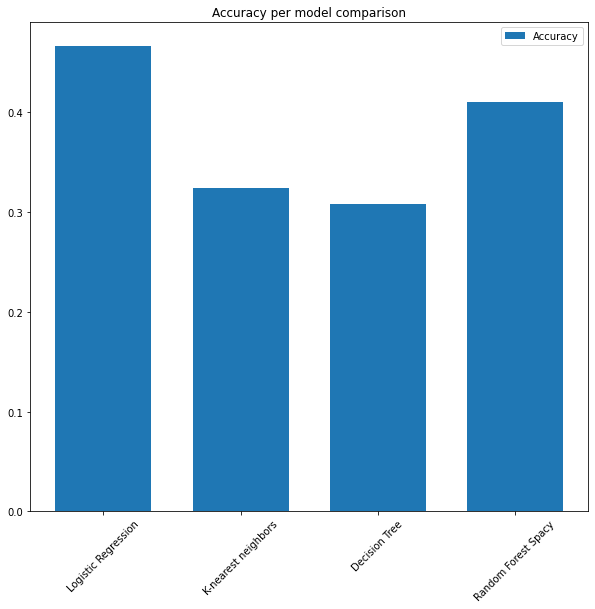

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10,9))

width = 0.70
labels = reports.keys()
report_values_accuracy = [x['accuracy'] for x in reports.values()]

ax.bar(labels, report_values_accuracy, 
        label='Accuracy', width=width)
plt.title("Accuracy per model comparison")
plt.xticks(rotation=45)
ax.legend()

In [56]:
pd.DataFrame(reports, index = ['accuracy','recall','precision','f1_score']).T

,accuracy,recall,precision,f1_score
Logistic Regression,0.466667,0.467678,0.464496,0.464014
K-nearest neighbors,0.323958,0.324282,0.340245,0.294198
Decision Tree,0.308333,0.307869,0.307111,0.304930
Random Forest Spacy,0.410417,0.412712,0.418713,0.400017
